In [4]:
import librosa
import tgt
import torch
from torchaudio.transforms import Resample
import numpy as np
from scipy.io.wavfile import read

from fastspeech2.audio import tools
from fastspeech2.utils import get_alignment
from fastspeech2.hparams import HyperParameters as hp

from matplotlib import pyplot as plt
%matplotlib inline  

/home/rokas/miniconda3/envs/mlp/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
vctk_file_1 = "/home/rokas/year4/mlp/cw3/data/datasets/VCTK/wav48/p236/p236_363.wav"
vctk_tg_file_1 = "/home/rokas/year4/mlp/cw3/data/datasets/VCTK/preprocessed/TextGrid/p236/p236_363.TextGrid"
vctk_file_2 = "/home/rokas/year4/mlp/cw3/data/datasets/VCTK/wav48/p307/p307_363.wav"
vctk_tg_file_2 = "/home/rokas/year4/mlp/cw3/data/datasets/VCTK/preprocessed/TextGrid/p307/p307_363.TextGrid"

In [3]:
lspeech_file_1 = "/home/rokas/year4/mlp/cw3/data/datasets/LJSpeech/wavs/LJ023-0098.wav"
lspeech_tg_file_1 = "/home/rokas/year4/mlp/cw3/data/datasets/LJSpeech/preprocessed/TextGrid/LJ023-0098.TextGrid" 
lspeech_file_2 = "/home/rokas/year4/mlp/cw3/data/datasets/LJSpeech/wavs/LJ008-0213.wav"
lspeech_tg_file_2 = "/home/rokas/year4/mlp/cw3/data/datasets/LJSpeech/preprocessed/TextGrid/LJ008-0213.TextGrid" 

In [68]:
def process_utterance(wav_file, tg_path, start=None, end=None):       
    # Get alignments
    textgrid = tgt.io.read_textgrid(tg_path)
    
    phone, duration, start_orig, end_orig = get_alignment(textgrid.get_tier_by_name('phones'))
    if start is None or end is None:
        start = start_orig
        end = end_orig
        
    text = '{'+ '}{'.join(phone) + '}' # '{A}{B}{$}{C}', $ represents silent phones
    text = text.replace('{$}', ' ')    # '{A}{B} {C}'
    text = text.replace('}{', ' ')     # '{A B} {C}'
    
    if start >= end:
        return None

    # Read and trim wav files
  
    sr, wav = read(wav_file) 
    wav = torch.FloatTensor(wav.astype(np.float32))
    if sr != hp.sampling_rate:
        wav = Resample(orig_freq=sr, new_freq=hp.sampling_rate)(wav)
    
    print("Start: {}, end: {}".format(start, end))
    print("Waveform max: {}".format(wav.max()))
    print("Waveform min: {}".format(wav.min()))
    print("Waveform length: {}".format(len(wav)/sr))

    wav = wav[int(hp.sampling_rate*start):int(hp.sampling_rate*end)]
    print("Aligned waveform length: {}".format(len(wav)/sr))

    # Compute mel-scale spectrogram and energy
    mel_spectrogram, energy = tools.get_mel_from_wav(wav)
    plt.imshow(mel_spectrogram)
    plt.savefig(wav_file[:-3].split("/")[-1] + "png")
    plt.show()
    
    mel_spectrogram = mel_spectrogram.cpu().numpy().astype(np.float32)[:, :sum(duration)]
    energy = energy.cpu().numpy().astype(np.float32)[:sum(duration)]
    print("Energy max: {}".format(energy.max()))
    print("Energy min: {}".format(energy.min()))
    if mel_spectrogram.shape[1] >= hp.max_seq_len:
        return None

In [14]:
import os

vctk_spkers = os.listdir("/home/rokas/year4/mlp/cw3/data/datasets/VCTK/txt")
vctk_spkers.sort()
max_val = 0
for spker in vctk_spkers:
    for txt_file in os.listdir(os.path.join("/home/rokas/year4/mlp/cw3/data/datasets/VCTK/txt", spker)):
        with open(os.path.join("/home/rokas/year4/mlp/cw3/data/datasets/VCTK", 
                               'txt', spker, txt_file), encoding='utf-8') as f:
            
            basename = txt_file.replace(".txt", "")
            wav_path = os.path.join("/home/rokas/year4/mlp/cw3/data/datasets/VCTK", 
                                    'wav48', spker, '{}.wav'.format(basename))
            sr, wav = read(wav_path)
            wav = wav.astype(np.float32) 
            orig_max = np.max(np.abs(wav))
            
            wav = torch.tensor(wav)
            if sr != hp.sampling_rate:
                wav = Resample(orig_freq=sr, new_freq=hp.sampling_rate)(wav)
            
            if torch.max(torch.abs(wav)) > max_val:
                max_val = torch.ceil(torch.max(torch.abs(wav)))
                print("Resampled: {}, original: {}".format(max_val.item(), orig_max))

Resampled: 18465.0, original: 18446.0
Resampled: 19179.0, original: 19480.0
Resampled: 27444.0, original: 27656.0
Resampled: 31715.0, original: 31694.0
Resampled: 32939.0, original: 32767.0
Resampled: 32966.0, original: 32767.0
Resampled: 33015.0, original: 32767.0
Resampled: 33078.0, original: 32767.0
Resampled: 33123.0, original: 32767.0
Resampled: 33261.0, original: 32767.0
Resampled: 33315.0, original: 32767.0
Resampled: 33322.0, original: 32767.0
Resampled: 33355.0, original: 32767.0
Resampled: 33382.0, original: 32767.0
Resampled: 33578.0, original: 32767.0
Resampled: 33900.0, original: 32565.0
Resampled: 34170.0, original: 32767.0
Resampled: 34223.0, original: 32510.0
Resampled: 38210.0, original: 32767.0


Start: 0.0, end: 4.0
Waveform max: 14331.0
Waveform min: -12244.0
Waveform length: 2.514875283446712
Aligned waveform length: 2.514875283446712


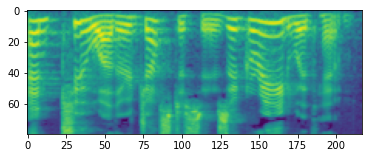

Energy max: 76.54315948486328
Energy min: 0.21685053408145905


In [69]:
process_utterance(lspeech_file_1, lspeech_tg_file_1, 0.0, 4.0)

Start: 0.0, end: 3.99
Waveform max: 15969.0
Waveform min: -16605.0
Waveform length: 4.03578231292517
Aligned waveform length: 3.9899773242630387


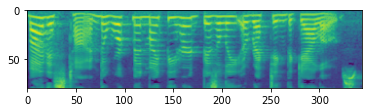

Energy max: 94.8462905883789
Energy min: 0.501575767993927


In [70]:
process_utterance(lspeech_file_2, lspeech_tg_file_2)

Start: 0.0, end: 10.0
Waveform max: 8469.9912109375
Waveform min: -7358.38671875
Waveform length: 1.0193958333333333
Aligned waveform length: 1.0193958333333333


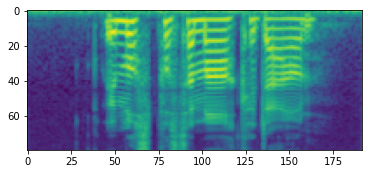

Energy max: 49.52248001098633
Energy min: 0.8269551992416382


In [77]:
process_utterance(vctk_file_1, vctk_tg_file_1, 0.0, 10.0)

Start: 0.46, end: 1.92
Waveform max: 8469.9912109375
Waveform min: -7358.38671875
Waveform length: 1.0193958333333333
Aligned waveform length: 0.6706875


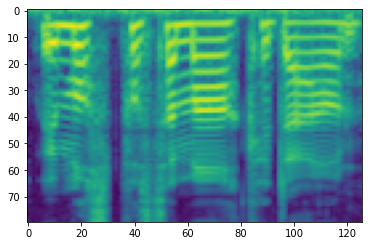

Energy max: 48.1438102722168
Energy min: 0.7762499451637268


In [75]:
process_utterance(vctk_file_1, vctk_tg_file_1)

Start: 1.28, end: 3.92
Waveform max: 9927.7177734375
Waveform min: -9670.861328125
Waveform length: 2.2169166666666666
Aligned waveform length: 1.21275


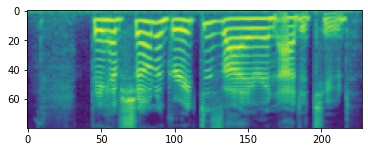

Energy max: 51.522274017333984
Energy min: 0.7083940505981445


In [79]:
process_utterance(vctk_file_2, vctk_tg_file_2)

Start: 0.0, end: 10.0
Waveform max: 9927.7177734375
Waveform min: -9670.861328125
Waveform length: 2.2169166666666666
Aligned waveform length: 2.2169166666666666


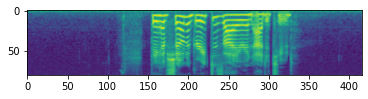

Energy max: 51.338584899902344
Energy min: 0.5653011202812195


In [80]:
process_utterance(vctk_file_2, vctk_tg_file_2, 0.0, 10.0)